In [1]:
import sys
sys.path.insert(1, '../')
from scripts.plot_utils import *
from scripts.preprocessing import *
from scripts.clustering_utils import *
from scripts.biomass_export import *
from omegaconf import OmegaConf

import joblib
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

from cartopy.feature import OCEAN, RIVERS
import matplotlib.patheffects as pes
import numpy as np
from matplotlib.lines import Line2D
from cmap import Colormap

%load_ext autoreload 
%autoreload 2

cfg = OmegaConf.load('glob_config.yaml')

In [2]:
def plot_export_values_with_errorbar(exports, errors, ax, c, l):
    max_exports = exports + errors
    min_exports = exports - errors
    y = [[1, max_exports.iloc[0]], [2, max_exports.iloc[1]], [5, max_exports.iloc[2]], [10, max_exports.iloc[3]], [15, max_exports.iloc[4]],
         [15, min_exports.iloc[4]], [10, min_exports.iloc[3]], [5, min_exports.iloc[2]], [2, min_exports.iloc[1]], [1, min_exports.iloc[0]]]
    
    
    polygon = mpatches.Polygon(y, alpha = 0.2, color = c)
    ax.add_patch(polygon)

    ax.plot([1, 2, 5, 10, 15], exports, label = l, color = c, marker = 'o')

    #ax.legend()

    return ax

def prepare_export_errors_data(ebu):

    cols = ['1year', '2years', '5years', '10years', '15years']

    export_files = [f'{ebu}/{col}/outputs/carbon_exports.csv' for col in cols]

    regions = read_region_input_files(f'{ebu}/2years/regions.input')

    groups = obtain_boxes_grouping(regions)

    export_dataset = pd.DataFrame(index = regions.keys(), columns = cols)
    errors_dataset = pd.DataFrame(index = regions.keys(), columns = cols)

    for file, c in zip(export_files, ['1year', '2years', '5years', '10years', '15years']):
        export = pd.read_csv(file, index_col = 0)
        export_dataset[c] = [export.loc[g]['export'].sum().T for g in groups]
        errors_dataset[c] = [export.loc[g]['error'].sum().T for g in groups]

    return export_dataset, errors_dataset

def plot_sensitivity_export(ax, region, colors):

    export_dataset, errors_dataset = prepare_export_errors_data(region)
    for d, l, c  in zip(export_dataset.index, export_dataset.index, colors):
        plot_export_values_with_errorbar(export_dataset.loc[d], errors_dataset.loc[d], ax, c, l)

    #ax.legend()
    ax.set_xlabel('Clustering years', fontsize = 15)
    ax.set_title('Export value [TgC yr$^{-1}$]', fontsize = 15)
    ax.set_xticks([1, 2, 5, 10, 15])
    ax.grid()

    return ax

def plot_num_streamers(ax, region, colors):

    dataset = compute_number_streamers(region)
    for l, c  in zip(dataset.index, colors):
        ax.plot([1, 2, 5, 10, 15], dataset.loc[l], label = l, color = c, marker = 'o')

    #ax.legend()
    ax.set_xlabel('Clustering years', fontsize = 15)
    ax.set_title('Number of pixels labelled as streamers', fontsize = 15)
    ax.set_xticks([1, 2, 5, 10, 15])
    ax.grid()

    return ax
    
def compute_number_streamers(ebu):

    cols = ['1year', '2years', '5years', '10years', '15years']

    mask_path = [f'{ebu}/{col}/outputs/streamers_masks/' for col in cols]

    regions = read_region_input_files(f'{ebu}/regions.input')

    groups = obtain_boxes_grouping(regions)

    dataset = pd.DataFrame(index = regions.keys(), columns = cols)
    
    for file, c in zip(mask_path, ['1year', '2years', '5years', '10years', '15years']):
        
        dataset[c] = [np.sum([xr.open_dataarray(os.path.join(file, f"box_{box}.nc")).sum() for box in group]) for group in groups]

    return dataset
    
    

In [3]:
def compute_available_pct(region_folder, years_list):

    regions = read_region_input_files(f'{region_folder}/regions.input')
    groups = obtain_boxes_grouping(regions)

    region_idxs = []
    year_idxs = []
    for key in regions.keys():
        region_idxs += [key] * 5
        year_idxs += ['1 year', '2 years', '5 years', '10 years', '15 years']

    region_idxs = np.array(region_idxs)
    year_idxs = np.array(year_idxs)

    # Compute number of pixels that are not available because of bathymetry filter
    bathymetry = xr.open_dataarray('/data01/benassi/export-biomass/data/processed/bathymetry.nc')

    # Number of removed points because of bathymetry for each 10x10 square
    bathy_avails = [[(crop_square(bathymetry, box) >= cfg.ref_depth).sum() for box in region] for region in regions.values()]


    pct_values = dict()

    for region, group, masks in zip(regions, groups, bathy_avails):
        
        # binary boxes with mapped cloud cover have already been generated. True = isnan = unavailable
        # in this way we import data where True = notnan
        boxes = [~xr.open_dataset(f'{region_folder}/outputs/data_availability/box_{n_box}.nc') for n_box in group]

        pct_per_region_over_slices = []

        for year_slice in years_list:
            # Select the year slice used for training
            train_set = [box.sel(time = year_slice) for box in boxes]

            # Compute the number of points that are marked as non nans
            available_points = np.sum([box.sum().to_array() for box in train_set], axis = 0)
            
            # Total count is the total number of points, but the shelf mask has to be removed
            total_count = [(box.count() - mask * len(box.time)).to_array() for box, mask in zip(train_set, masks)]

            # Obtain a single number over the whole dynamical region for chl, sst and eudepth
            total_count = np.sum(total_count, axis = 0)
            pct_per_region_over_slices.append(available_points / total_count * 100)
        
        pct_values[region] = pct_per_region_over_slices

    return pd.DataFrame(np.array(list(pct_values.values())).reshape(15, 3), index= [region_idxs, year_idxs], columns = ['chl', 'sst', 'eudepth'] )

def compute_available_points(region_folder, years_list):

    regions = read_region_input_files(f'{region_folder}/regions.input')
    groups = obtain_boxes_grouping(regions)

    region_idxs = []
    year_idxs = []
    for key in regions.keys():
        region_idxs += [key] * 5
        year_idxs += ['1 year', '2 years', '5 years', '10 years', '15 years']

    region_idxs = np.array(region_idxs)
    year_idxs = np.array(year_idxs)


    num_values = dict()

    for region, group in zip(regions, groups):
        
        # binary boxes with mapped cloud cover have already been generated. True = isnan = unavailable
        # in this way we import data where True = notnan
        boxes = [~xr.open_dataset(f'{region_folder}/data_availability/box_{n_box}.nc') for n_box in group]
        
        num_per_region_over_slices = []

        for year_slice in years_list:
            # Select the year slice used for training
            train_set = [box.sel(time = year_slice) for box in boxes]

            # Compute the number of points that are marked as non nans
            available_points = np.sum([box.sum().to_array() for box in train_set], axis = 0)

            num_per_region_over_slices.append(available_points)
        
        num_values[region] = num_per_region_over_slices

    return pd.DataFrame(np.array(list(num_values.values())).reshape(15, 3), index= [region_idxs, year_idxs], columns = ['chl', 'sst', 'eudepth'] )


def plot_availability(ax, availability_df, colors):

    #fig, ax = plt.subplots(figsize = [8, 5])
    lines = []
    for c, style in zip(['chl', 'sst'], ['solid', 'dashed']):

        d = availability_df[c].unstack(0).loc[['1 year', '2 years', '5 years', '10 years', '15 years']].reset_index(drop = True)
        d = d[availability_df.index.get_level_values(0).unique()]
        d.index = [1, 2, 5, 10, 15]

        #if a == ax[1]:
        d.plot(ax = ax,
                color = colors,
                marker = '.',
                linestyle = style, legend = False)

    #else:
        # d.plot(ax = a,
        #     color = colors,
        #     marker = '.', legend = False)

    #ax.set_title(c)
    ax.set_xlabel('Clustering years', fontsize = 15)
    ax.grid()
    ax.set_xticks(d.index)
    ax.set_title('Available data', fontsize = 15)

    lines = [Line2D([0], [0], color="black", linestyle='solid', label = f"Chl-a")] +\
            [Line2D([0], [0], color="black", linestyle='dashed', label = f"SST")]
    
    ax.legend(handles=lines, ncol=2, loc = 'lower right', prop = {'size' : 12})
    # ax.add_artist(leg)

    #ax.legend(handles=handles, bbox_to_anchor=(1., -0.15), ncol=3)

    return ax

In [8]:
years_list = [slice('2003-01-01', '2003-12-31'),
              slice('2003-01-01', '2004-12-31'),
              slice('2003-01-01', '2007-12-31'),
              slice('2003-01-01', '2012-12-31'),
              slice('2003-01-01', '2017-12-31'),]

#pac_availability = compute_available_pct('../pacific', years_list)

In [40]:
pac_num_streamers = compute_number_streamers("pacific")

In [9]:
pac_availability_num = compute_available_points('pacific', years_list)

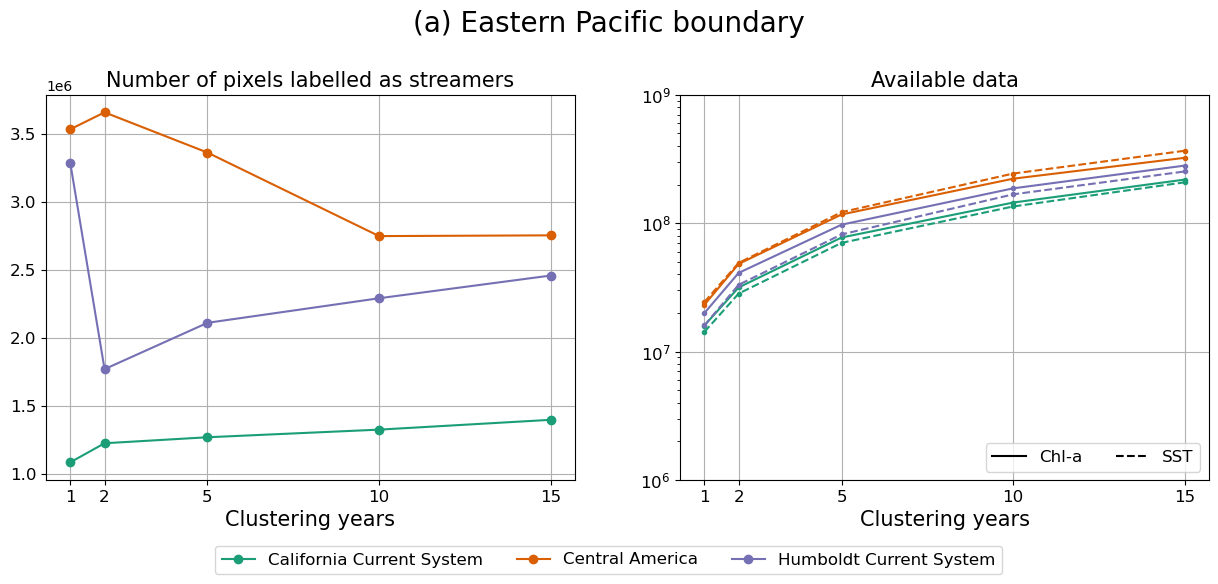

In [55]:
fig, ax = plt.subplots(ncols = 2, figsize = [15,5])
colors = ['#1b9e77', '#d95f02', '#7570b3']

for a in ax:
    a.tick_params(labelsize = 12)

#ax[0] = plot_sensitivity_export(ax[0], 'pacific', colors)
ax[0] = plot_num_streamers(ax[0], 'pacific', colors)
ax[1] = plot_availability(ax[1], pac_availability_num, colors)

ax[1].set_yscale('log')
ax[1].set_ylim([1e6, 1e9])

    
handles = [Line2D([0], [0], color=color, label = label, marker = 'o') for color, label in zip(colors, pac_availability_num.index.get_level_values(0).unique())] 
fig.legend(handles = handles, bbox_to_anchor=(0.5, -0.05), loc = 'center', ncol=3, prop = {'size' : 12})
fig.suptitle('(a) Eastern Pacific boundary', fontsize = 20, y = 1.05)

plt.savefig('../images/pacific_clustering_sensitivity_numstreamers.png', bbox_inches = 'tight')

In [48]:
years_list = [slice('2003-01-01', '2003-12-31'),
              slice('2003-01-01', '2004-12-31'),
              slice('2003-01-01', '2007-12-31'),
              slice('2003-01-01', '2012-12-31'),
              slice('2003-01-01', '2017-12-31'),]

#atl_availability = compute_available_pct('../atlantic', years_list)

atl_availability_num = compute_available_points('atlantic', years_list)

In [ ]:
atl_num_streamers = compute_number_streamers("atlantic")


In [51]:
atl_num_streamers

,1year,2years,5years,10years,15years
Canary Current System,1654814,1818070,1975310,1980942,2019358
Central Africa,150735,193998,136848,142741,156619
Benguela Current System,1644099,1007655,1021445,964189,1011960


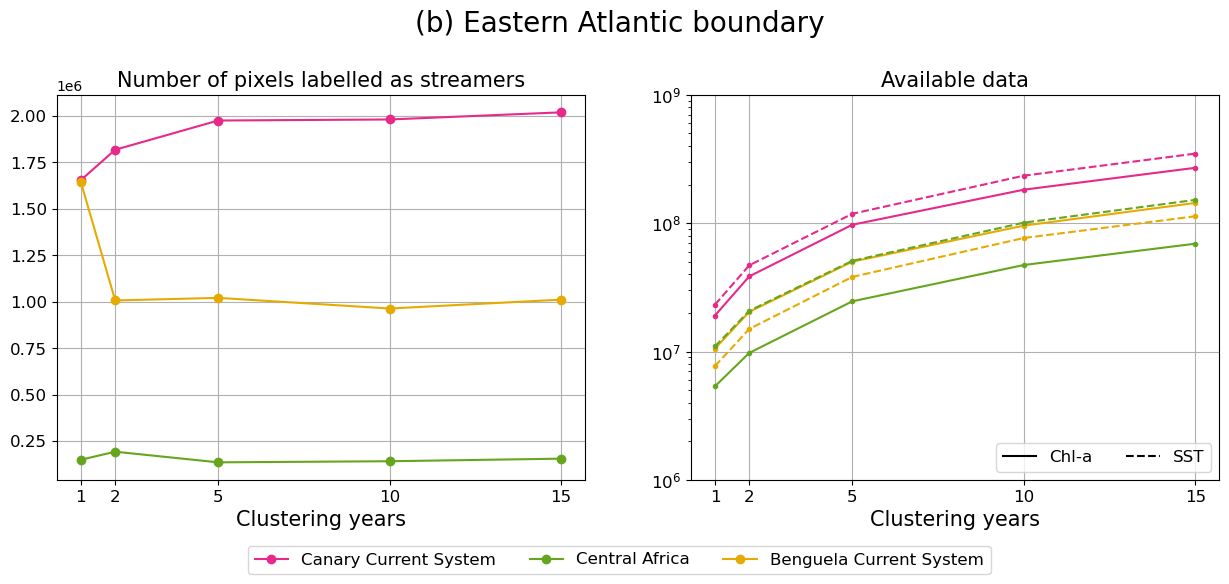

In [56]:

fig, ax = plt.subplots(ncols = 2, figsize = [15,5])
colors = ['#e7298a', '#66a61e', '#e6ab02']

for a in ax:
    a.tick_params(labelsize = 12)

#ax[0] = plot_sensitivity_export(ax[0], 'atlantic', colors)
ax[0] = plot_num_streamers(ax[0], 'atlantic', colors)
ax[1] = plot_availability(ax[1], atl_availability_num, colors)

ax[1].set_yscale('log')
ax[1].set_ylim([1e6, 1e9])

    
handles = [Line2D([0], [0], color=color, label = label, marker = 'o') for color, label in zip(colors, atl_availability_num.index.get_level_values(0).unique())] 
fig.legend(handles = handles, bbox_to_anchor=(0.5, -0.05), loc = 'center', ncol=3, prop = {'size' : 12})
fig.suptitle('(b) Eastern Atlantic boundary', fontsize = 20, y = 1.05)

#ax.set_title('Eastern Pacific boundary', fontsize = 15)
plt.savefig('../images/atlantic_clustering_sensitivity_numstreamers.png', bbox_inches = 'tight')

In [27]:
def compute_seasonality_pct(region_folder):
    regions = read_region_input_files(f'{region_folder}/regions.input')
    groups = obtain_boxes_grouping(regions)

    table = dict()

    # Compute number of pixels that are not available because of bathymetry filter
    bathymetry = xr.open_dataarray('/data01/benassi/export-biomass/data/processed/bathymetry.nc')

    # Number of removed points because of bathymetry for each 10x10 square
    bathy_avails = [[(crop_square(bathymetry, box) >= cfg.ref_depth).sum() for box in region] for region in regions.values()]

    for bathy, region, group in zip(bathy_avails, regions, groups):
        
        # binary boxes with mapped cloud cover have already been generated. True = isnan = unavailable
        # in this way we import data where True = notnan
        boxes = [~xr.open_dataset(f'{region_folder}/data_availability/box_{n_box}.nc')[['chl', 'sst']] for n_box in group]

        # Compute the number of points that are marked as non nans
        # Making sure that seasons are in the right order
        available_points =  np.sum(
            [
                box.groupby('time.season')\
                    .sum()\
                    .sel(season = ['DJF', 'MAM', 'JJA', 'SON'])\
                    .sum(['longitude', 'latitude'])\
                    .to_array() for box in boxes
            ], axis = 0
                
                                    )
        tot_points = np.sum([box.groupby('time.season').count().sel(season = ['DJF', 'MAM', 'JJA', 'SON']).sum(['longitude', 'latitude']).to_array() for box in boxes], axis = 0)

        #bathy_points = np.full(bathy, available_points.shape)
        #t = (available_points - bathy) / (tot_points - bathy) * 100
        print(available_points.shape)
        break
        table[region] = dict(chl = t[0], sst = t[1])

    # arrays = [[region for region in table.keys() for _ in range(2)],
    #             [var  for _ in range(2) for var in ['chl', 'sst']*len(table.keys())]]
    # tuples = list(zip(*arrays))

    # index = pd.MultiIndex.from_tuples(tuples, names = ['region', 'var'])

    # return pd.DataFrame(np.array([np.array(list(p.values())) for p in table.values()]).reshape(len(arrays[0]),-1), index = index, columns = ['DJF', 'MAM', 'JJA', 'SON'])



In [28]:
compute_seasonality_pct('pacific')

(2, 4)


In [142]:
pct_pacific = compute_seasonality_pct('pacific')

In [150]:
pct_pacific

DJF        MAM        JJA        SON
region                    var                                            
California Current System chl  22.230702  24.679430  20.609175  28.549291
                          sst  24.373342  21.311669  14.791175  27.528286
Central America           chl  39.558460  30.628741  18.147107  23.622474
                          sst  39.953943  34.522631  18.644754  24.152274
Humboldt Current System   chl  22.898098  21.128738  12.261947  15.463920
                          sst  17.976107  19.029751  14.031790  12.111257

In [143]:
pct_atlantic = compute_seasonality_pct('atlantic')

In [249]:
def plot_bars(dataframe, fig):
    
    ax = fig.subplots(nrows = 2, sharey = True, sharex = True)
    fig.subplots_adjust(hspace = 0.5)

    dataframe.swaplevel(0,1).loc['chl'].plot.bar(ax = ax[0], color = 'green', legend = False, edgecolor = 'k', alpha = .5)
    ax[0].tick_params(axis = 'y', labelsize = 12)
    ax[0].set_ylim([0, 45])
    ax[0].set_title('Chlorophyll-a concentration', fontsize = 15)

    dataframe.swaplevel(0,1).loc['sst'].plot.bar(ax = ax[1], color = 'red', legend = False, edgecolor = 'k', alpha = .5)
    ax[1].tick_params(axis = 'y', labelsize = 12)
    ax[1].tick_params(axis = 'x', rotation = 0, pad = 40, labelsize = 15)
    ax[1].set_xticks(np.array([i + di for i in range(0, 3) for di in [-0.1875, -0.0625, 0.0625, 0.1875]]), 
                    labels=list(pct_pacific.columns) * 3, 
                    minor = True, 
                    rotation = 90,
                    fontsize = 12)
    ax[1].set_xlabel('')
    ax[1].set_title('Sea surface temperature', fontsize = 15)


    fig.text(0.08, 0.5, 'Available points [%]', va='center', rotation='vertical', fontsize = 15)
    return fig, ax

Text(0.5, 1.05, 'b) Eastern Atlantic boundary')

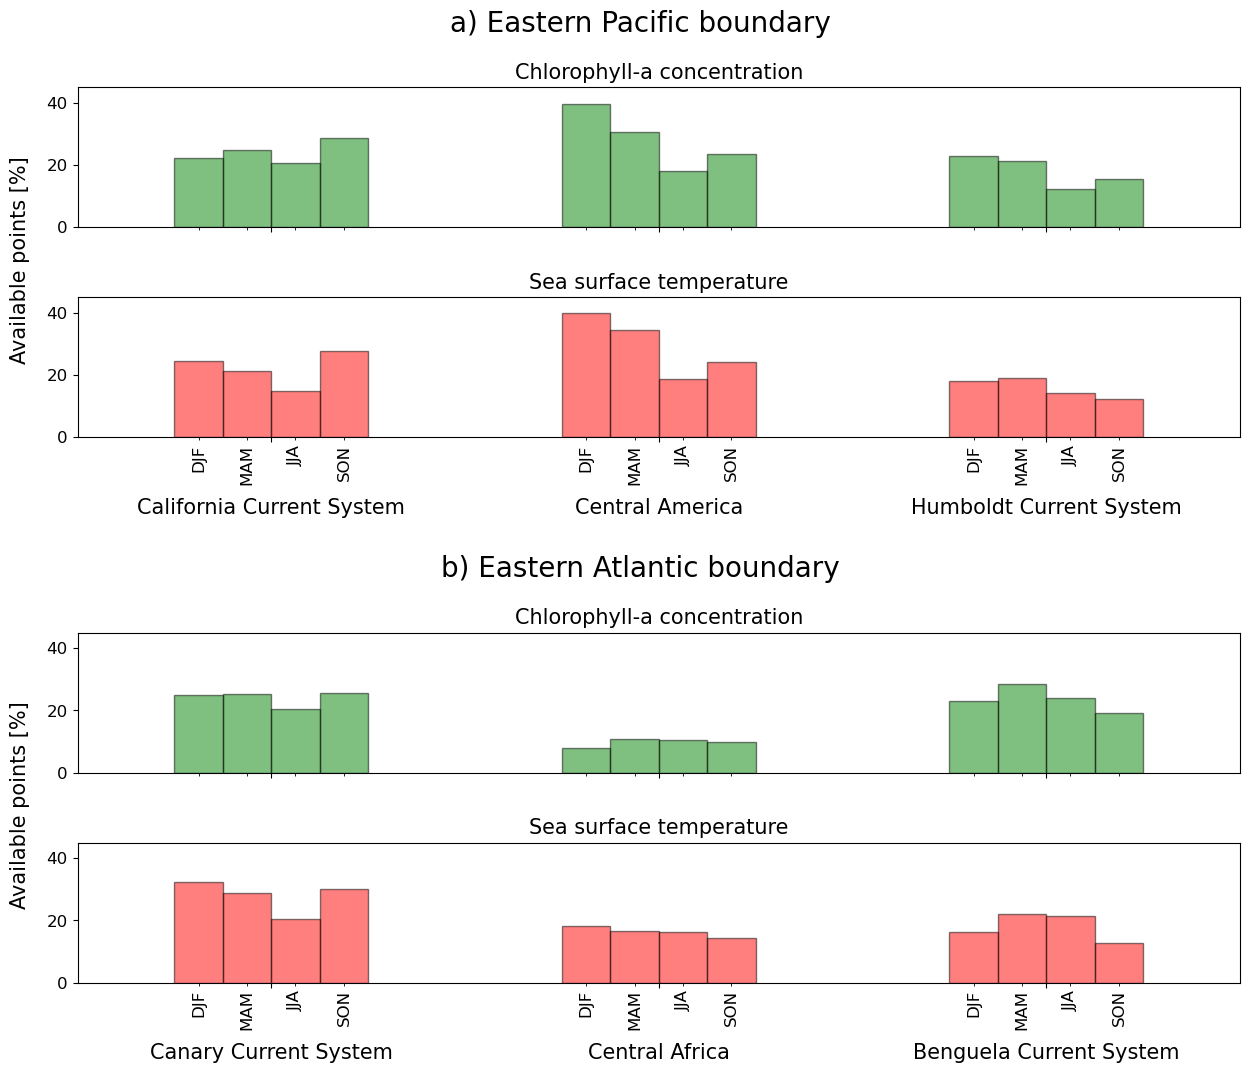

In [250]:
fig = plt.figure(figsize=(15, 10))
subfigs = fig.subfigures(2, 1, wspace=0.5)


plot_bars(pct_pacific, subfigs[0])
subfigs[0].suptitle('a) Eastern Pacific boundary', fontsize = 20, y = 1.05)

plot_bars(pct_atlantic, subfigs[1])
subfigs[1].suptitle('b) Eastern Atlantic boundary', fontsize = 20, y = 1.05)